<head>
    <style>
        .md-typeset h2 {
            margin:0;
            }
        .md-typeset h3 {
            margin:0;
            }
        .jupyter-wrapper table.dataframe tr, .jupyter-wrapper table.dataframe th, .jupyter-wrapper table.dataframe td {
            text-align:left;
            }
        .jupyter-wrapper table.dataframe {
            table-layout: auto;
            }
    </style>
</head>

# Matching and Subclassification 

In our last post, we have the following simple data frame. 

|   name | treatment | outcome |    id |
|-------:|----------:|--------:|------:|
|   Andy |         1 |      10 |     1 |
|    Ben |         1 |       5 |     2 |
|   Chad |         1 |      16 |     3 |
| Daniel |         1 |       3 |     4 |
|  Edith |         0 |       5 |     5 |
|  Frank |         0 |       7 |     6 |
| George |         0 |       8 |     7 |
|   Hank |         0 |      10 |     8 |

However, this kind of data assumes that each individual is almost _identical_,
which means all other factors (such as age or gender) could not affect 
the outcome. This is not the case for most observable or experimental dataset.
To solve this problem, we need to match features for treatment group and 
control group. We need so called identification assumptions:

1. conditional independence $(Y^1, Y^0) \perp D | X$ 
2. common support $0 < Pr(D = 1 | X) < 1$

These two assumptions yield the following identity
$$
\begin{aligned}
E\left[Y^1-Y^0 \mid X\right] &=E\left[Y^1-Y^0 \mid X, D=1\right] \\
&=E\left[Y^1 \mid X, D=1\right]-E\left[Y^0 \mid X, D=0\right] \\
&=E[Y \mid X, D=1]-E[Y \mid X, D=0]
\end{aligned}
$$
where each value of $Y$ is determined by the switching equation. Given common support, we get the following estimator:
$$
\widehat{\delta_{A T E}}=\int(E[Y \mid X, D=1]-E[Y \mid X, D=0]) d \operatorname{Pr}(X)
$$

In [1]:
# load packages 
library(pacman)
p_load(tidyverse, data.table, stats, ri2, haven, 
                    ggdag, vcd, stargazer, Matching, FNN)
options(dplyr.summarise.inform = FALSE)
options(repr.plot.width=9, repr.plot.height=5)  # figsize

## Titanic data set 

We will use the Titanic dataset to check whether people from the first class
division have the higher surviving rate. 

In [2]:
titanic <- read_dta("https://github.com/scunning1975/mixtape/raw/master/titanic.dta")
cbind(head(titanic), tail(titanic))

class,age,sex,survived,class,age,sex,survived
<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>
1,1,1,1,4,1,0,1
1,1,1,1,4,1,0,1
1,1,1,1,4,1,0,1
1,1,1,1,4,1,0,0
1,1,1,1,4,1,0,0
1,1,1,1,4,1,0,0


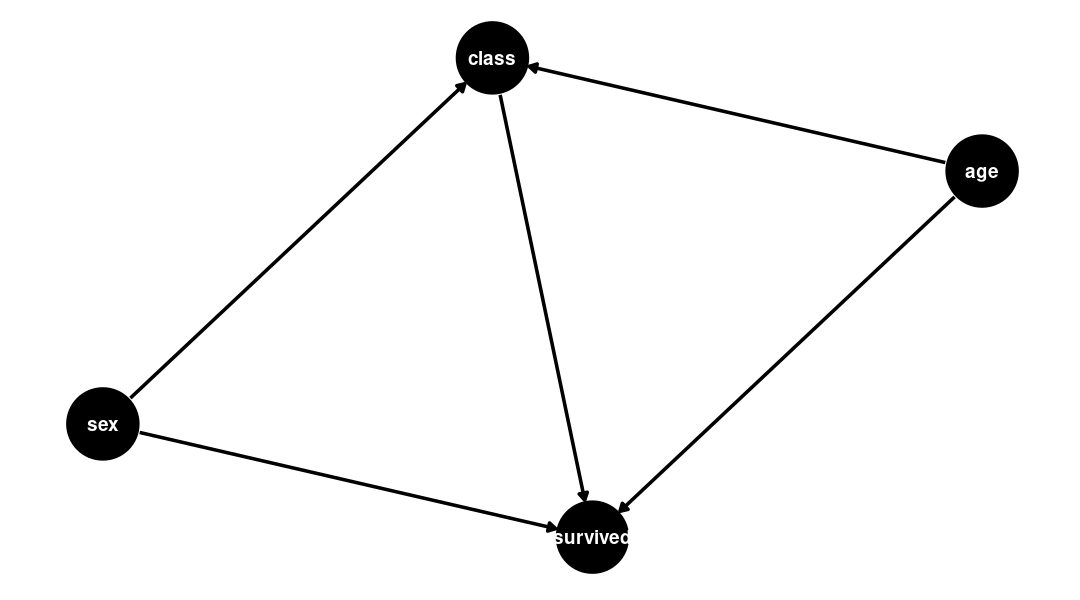

In [3]:
# create directed acyclic graph
options(repr.plot.width=9, repr.plot.height=5)  # figsize
dagify(
    survived ~ class + age + sex,
    class ~ age,
    class ~ sex,
    exposure = "class",
    outcome = "survived"
    ) %>%
    tidy_dagitty() %>%
    ggplot(aes(x=x, y=y, xend=xend, yend=yend)) +
    geom_dag_point(size=20) +
    geom_dag_edges(edge_width=1) +
    geom_dag_text() +
    theme_dag()

In [4]:
# check differences of survival based on sex and age
titanic %>%
    mutate(d=case_when(class == 1 ~ 1, TRUE ~ 0)) %>%
    group_by(d) %>%
    summarize(srv_mean=mean(survived)) %>%
    t() %>% as.data.frame() %>% 
    mutate(simple_diff=V2-V1) %>%
    round(3)

,V1,V2,simple_diff
,<dbl>,<dbl>,<dbl>
d,0.000,1.000,1.000
srv_mean,0.271,0.625,0.354


Using the data set on the Titanic, we calculate a simple difference in mean 
outcomes (SDO), which finds that being seated in first class raised the 
probability of survival by 35.4%. But note, since this does not adjust 
for observable confounders age and gender, it is a biased estimate of 
the ATE. So next we use subclassification weighting to control for these 
confounders. Here are the steps that will entail:

1. Stratify the data into four groups: young males, young females, old males, old females.

2. Calculate the difference in survival probabilities for each group.

3. Calculate the number of people in the non-first-class groups and divide by the total number of non-first-class population. These are our strata-specific weights.

4. Calculate the weighted average survival rate using the strata weights.

In [5]:
titanic %>%
    # stratify the data into different group
    mutate(
        first_class=case_when(class==1 ~ 1, TRUE ~ 0),
        covariate_group=case_when(
            age==0 & sex==0 ~ 1,
            age==0 & sex==1 ~ 2,
            age==1 & sex==0 ~ 3, 
            age==1 & sex==1 ~ 4,
            TRUE ~ 0)
        ) %>%
        # calculate conditional mean for each group
        group_by(first_class, covariate_group) %>%
        summarize(
            conditional_mean=mean(survived),
            freq=n()) %>%
        # calculate frequency and share for first_class=0/1 
        group_by(first_class) %>%
        mutate(weight=freq/sum(freq)) %>%
        select(-freq) %>%
        pivot_wider(
            names_from=covariate_group,
            values_from=c(conditional_mean, weight),
            names_prefix="group"
        ) %>% t() %>% as.data.frame() %>%
        setNames(c("control", "treatment")) -> res

cbind(res[2:5, ], res[6:9,1]) %>%
    setNames(c("control", "treatment", "support_weight")) %>%
    # calculate the difference
    mutate(diff=treatment-control) %>%
    # calculate the weighted difference
    mutate(weighted_diff=support_weight*diff) -> res

rbind(res, colSums(res)) -> res
rownames(res)[5] <- "total"
round(res, 3)

,control,treatment,support_weight,diff,weighted_diff
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
conditional_mean_group1,0.614,1.000,0.023,0.386,0.009
conditional_mean_group2,0.407,1.000,0.031,0.593,0.019
conditional_mean_group3,0.626,0.972,0.150,0.346,0.052
conditional_mean_group4,0.188,0.326,0.795,0.137,0.109
total,1.835,3.298,1.000,1.463,0.189


Here we find that once we condition on the confounders gender and age, 
first-class seating has a much lower probability of survival associated with 
it (though frankly, still large). The weighted ATE is 18.9%, 
versus the SDO, which is 35.4%.

In [6]:
titanic %>%
    mutate(first_class=case_when(class==1 ~ 1, TRUE ~ 0)) %>%
    group_by(first_class, age, sex) %>%
    count(survived) %>%
    mutate(stratum_size=sum(n), share=n/stratum_size*100) %>%
    mutate(first_class=recode(
        first_class, `0`="Non-first Class", `1`="First Class"
        ),
        age=recode(
            factor(age), `0`="Children", `1`="Adults"
        ),
        sex=recode(
            factor(sex), `0`="Female", `1`="Male"
        ),
        survived=recode(
            factor(survived), `0`="No", `1`="Yes"
        )
    ) -> contingency_table

contingency_table

first_class,age,sex,survived,n,stratum_size,share
<chr>,<fct>,<fct>,<fct>,<int>,<int>,<dbl>
Non-first Class,Children,Female,No,17,44,38.636364
Non-first Class,Children,Female,Yes,27,44,61.363636
Non-first Class,Children,Male,No,35,59,59.322034
Non-first Class,Children,Male,Yes,24,59,40.677966
Non-first Class,Adults,Female,No,105,281,37.366548
Non-first Class,Adults,Female,Yes,176,281,62.633452
Non-first Class,Adults,Male,No,1211,1492,81.166220
Non-first Class,Adults,Male,Yes,281,1492,18.833780
First Class,Children,Female,Yes,1,1,100.000000


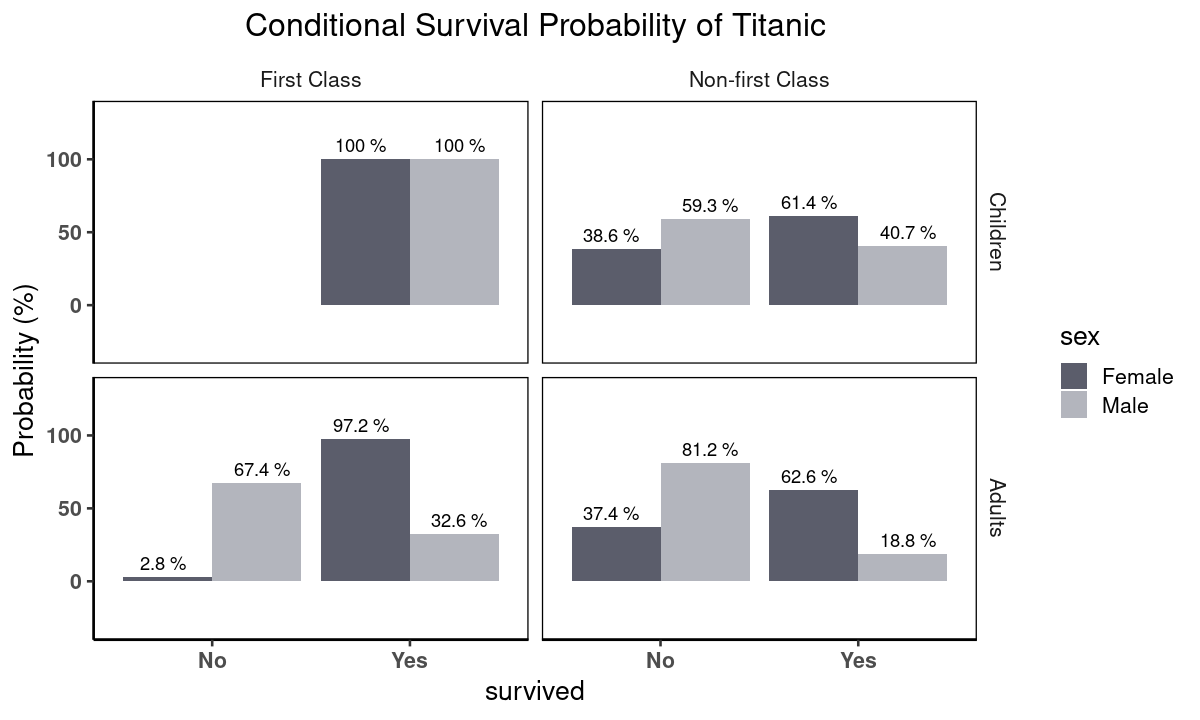

In [7]:
# visualize the probability
options(repr.plot.width=10, repr.plot.height=6)  # figsize
contingency_table %>%
    ggplot(
        aes(x=survived, y=share, fill=sex)
    ) +
    geom_col(position="dodge") +
    facet_grid(age~first_class) +
    theme_classic(base_size=16) +
    scale_fill_manual(
        values=c("#5B5D6B", "#B3B5BD")
    ) +
    geom_text(
        aes(
            x=survived, y=share, group=sex,
            label=paste(round(share, 1), "%")
            ),
            position = position_dodge(width=1),
            vjust=-0.5
    ) + 
    labs(
        title="Conditional Survival Probability of Titanic",
        y="Probability (%)"
    ) + 
    scale_y_continuous(expand = c(0.4,0.1)) + 
    theme(plot.title=element_text(hjust=0.5),
            axis.text.x=element_text(face='bold'),
            axis.text.y=element_text(face='bold'),
            strip.background = element_blank(),
            panel.border = element_rect(colour = "black", fill = NA)
    )


## Curse of dimensionality

When we match our dataset, it is necessary to have a fair amount of data
points for each feature we select. This gives us the common support. However,
subclassification becomes less feasible as the number of covariates grows, 
because as number of features grows, the data becomes sparse. Imagine if we 
tried to add a third strata, say, race (black and white). Then we’d have two 
age categories, two gender categories, and two race categories, giving us 
eight possibilities. In this small sample, we probably will end up with 
many cells having missing information. This is called the curse of dimensionality. 
If sparseness occurs, it means many cells may contain either only treatment 
units or only control units, but not both. If that happens, we can’t use 
subclassification, because we do not have common support. And 
therefore we are left searching for an alternative method to satisfy the 
backdoor criterion.

Imagine we have 10 features and how many possibilities could we have? In
this case, it is a _power set_, then we could have $2^10 = 1024$ possibilities.
This brings a problem when we sample our dataset. 

<div class="result">
    <details class="tip"> 
        <summary>Tips</summary> 
        <p>
        Matching is a local method. This kind of method does not work well
        for the high dimension as data becomes very sparse, which makes
        the amount of training data needed to cover a certain percent
         of the feature (say $20%$) range grows exponentially with the 
         number of dimensions.
        </p>
        <p>
        In other words, if the amount of available training data is fixed, 
        then overfitting occurs if we keep adding dimensions. On the other 
        hand, if we keep adding dimensions, the amount of training data 
        needs to grow exponentially fast to maintain the same coverage 
        and to avoid overfitting.
        </p>
    </details> 
</div>

To solve the data sparsity issue, we need to do _exact matching_ process. 


## Exact matching 

If observation $i$ is treated, in other words, then we need to fill in 
the missing $Y_i^0$ using the control matches, and if the observation $j$ is a control 
group unit, then we need to fill in the missing $Y_j^1$ using the treatment 
group matches. Here is the formula: 

$$
\hat{\delta}_{A T E}=\frac{1}{N} \sum_{i=1}^N\left(2 D_i-1\right)\left[Y_i-\left(\frac{1}{M} \sum_{m=1}^M Y_{j_m(i)}\right)\right]
$$

In [8]:
# an example
em <- read_dta("https://github.com/scunning1975/mixtape/raw/master/training_example.dta") %>%
    slice(1:20) %>%
    select(-c(unit_matched, age_matched, earnings_matched))
em1 <- em[1:10, 1:3] %>%
    mutate(treatment=rep(1, 10)) %>%
    setNames(c("unit", 'age', 'earnings', 'trainees'))
em2 <- em[1:20, 4:6] %>%
    mutate(treatment=rep(0, 20)) %>%
    setNames(c("unit", 'age', 'earnings', 'trainees'))

em <- rbind(em1, em2)
cbind(head(em), tail(em))

unit,age,earnings,trainees,unit,age,earnings,trainees
<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,18,9500,1,15,43,13675,0
2,29,12250,1,16,39,12775,0
3,24,11000,1,17,19,8275,0
4,27,11750,1,18,30,9000,0
5,33,13250,1,19,51,15475,0
6,22,10500,1,20,48,14800,0


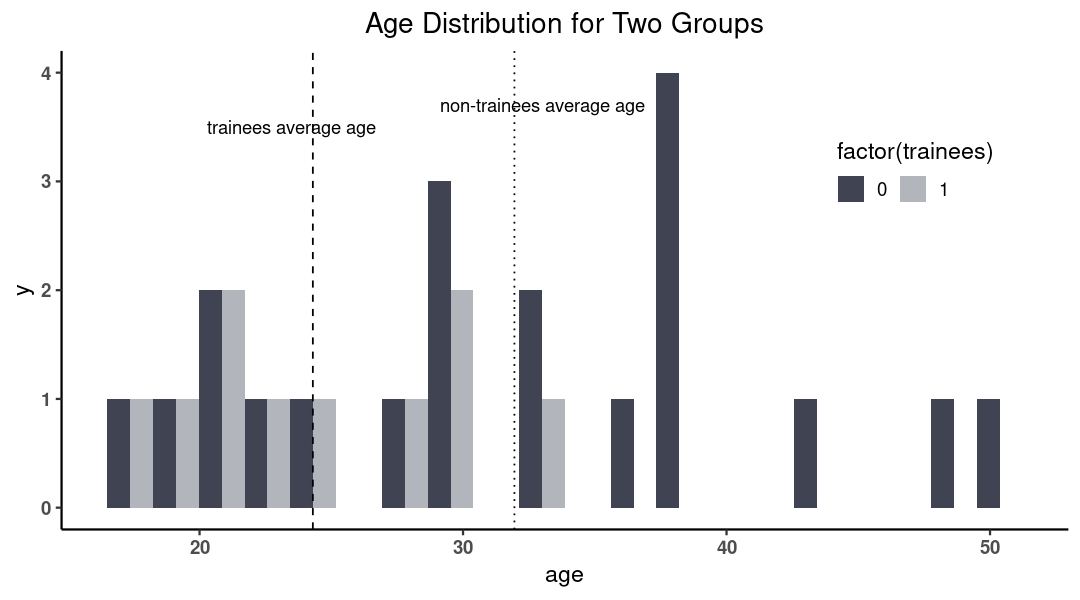

In [9]:
options(repr.plot.width=9, repr.plot.height=5)  # figsize
em %>%
    ggplot(aes(x=age, fill=factor(trainees))) + 
    geom_histogram(bins=20, position='dodge') +
    geom_vline(
        aes(xintercept=mean(em[trainees==1,]$age)),
        linetype='dashed'
    )+
    geom_vline(
        aes(xintercept=mean(em[trainees==0,]$age)),
        linetype='dotted'
    )+
    theme_classic(base_size=14) +
    scale_fill_manual(values=c('#404352', '#B3B5BD')) +
    labs(
        title="Age Distribution for Two Groups"
    ) + 
    theme(plot.title=element_text(hjust=0.5),
            axis.text.x=element_text(face='bold'),
            axis.text.y=element_text(face='bold'),
            legend.position=c(0.85, 0.75)
    ) +
    guides(fill=guide_legend(nrow = 1)) +
    annotate(
        geom='text',
        x=23.5, y=3.5,
        label='trainees average age'
    ) +
    annotate(
        geom='text',
        x=33, y=3.7,
        label='non-trainees average age'
    )

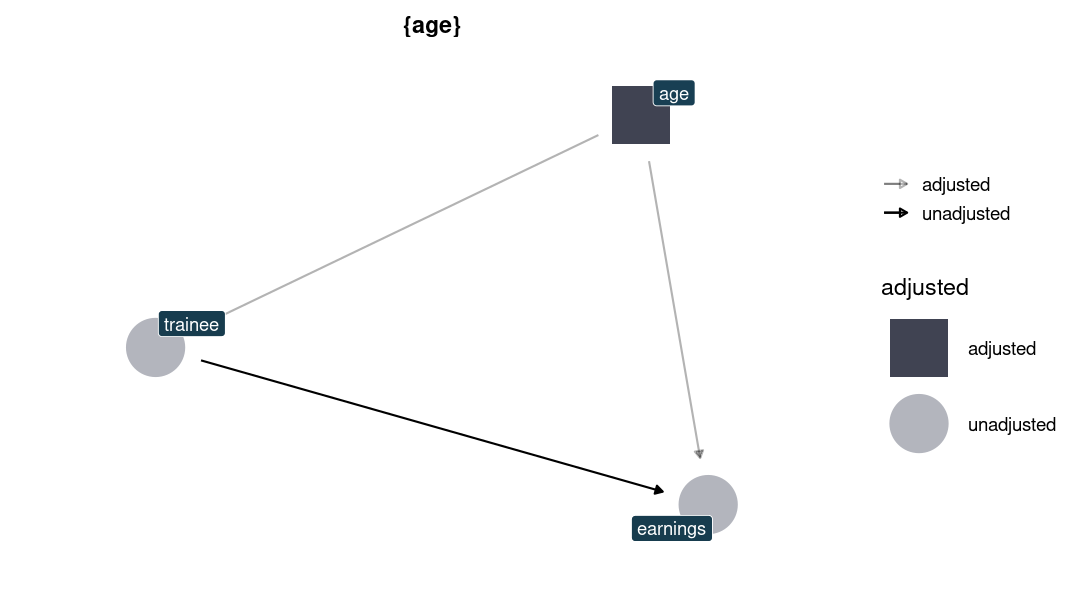

In [10]:
# therefore, we need to control age 
dag_trainees <- dagify(earnings ~ age + trainee,
                       trainee ~ age,
                       exposure = "trainee",
                       outcome = "earnings")

ggdag_adjustment_set(dag_trainees,
                     text = FALSE,
                     use_labels = "name",
                     shadow = TRUE) +
theme_dag(base_size=14) +
scale_color_manual(values=c('#404352', '#B3B5BD')) +
scale_fill_manual(values=c('#183f53', '#173c4e'))

In [11]:
# exact match based on age 
em %>%
    filter(trainees==1) -> em1
em %>% 
    filter(trainees==0) -> em2

 # choose the first value not average 
matched_data <- left_join(em1, em2, by='age')
matched_data

unit.x,age,earnings.x,trainees.x,unit.y,earnings.y,trainees.y
<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>
1,18,9500,1,14,8050,0
2,29,12250,1,6,10525,0
3,24,11000,1,9,9400,0
4,27,11750,1,2,10075,0
5,33,13250,1,8,11425,0
5,33,13250,1,11,11425,0
6,22,10500,1,13,8950,0
7,19,9750,1,17,8275,0
8,20,10000,1,1,8500,0


In [12]:
as.numeric(matched_data$earnings.x)

[1]  9500 12250 11000 11750 13250 13250 10500  9750 10000 10250 12500 12500

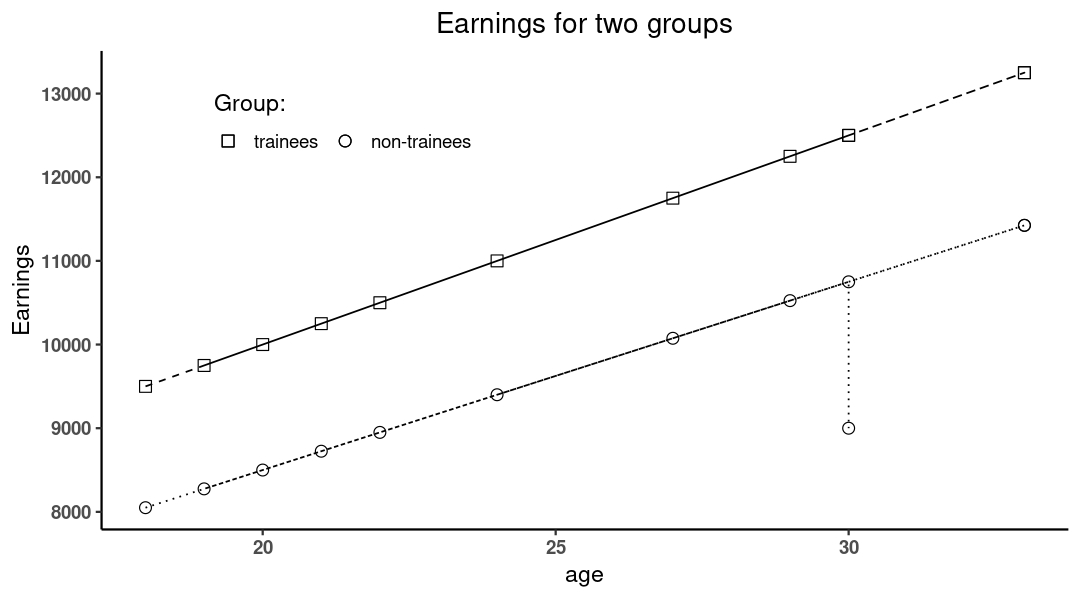

In [13]:
matched_data %>%
    ggplot(aes(x=age)) +
    geom_point(aes(y=as.numeric(earnings.x), shape='0'), size=3) +
    geom_point(aes(y=as.numeric(earnings.y), shape='1'), size=3) +
    geom_path(aes(y=as.numeric(earnings.x)), linetype='dashed') +
    geom_path(aes(y=as.numeric(earnings.y)), linetype='dotted') +
    labs(
        title='Earnings for two groups',
        y='Earnings'
    ) +
    theme_classic(base_size=14) +
    scale_shape_manual(
        name='Group:',
        values=c(0, 1),
        labels=c('trainees', 'non-trainees')
    ) + 
    theme(plot.title=element_text(hjust=0.5),
            axis.text.x=element_text(face='bold'),
            axis.text.y=element_text(face='bold'),
            legend.position=c(0.25, 0.85)
    ) +
    guides(shape=guide_legend(nrow = 1))

## Bias correction

Before we talking about bias correction. Let's review the key concepts again.
For the population, we have:

* true difference between two _states_: $Y_i^1 - Y_i^0$
* the expectation for population ATE$=E[Y_i^1 - Y_i^0]$

We could also conditional expectation for the treatment 

$$ATT=E[Y_i^1 - Y_i^0 | D_i=1];  \ \ \ \  ATU = E[Y_i^1 - Y_i^0 | D_i=0]$$

However, we can never have the true data for the population. Therefore,
we need the _identification_ assumptions. 

#### Identification Assumption

(1) $\left(Y_1, Y_0\right) \perp D \mid X$ (selection on observables)

(2) $0<\operatorname{Pr}(D=1 \mid X)<1$ with probability one (common support)

#### Identification Result

Given selection on observables we have
$$
\begin{aligned}
\mathbf{E}\left[Y_1-Y_0 \mid X\right] &=\mathbf{E}\left[Y_1-Y_0 \mid X, D=1\right] \\
&=\mathbf{E}[Y \mid X, D=1]-\mathbf{E}[Y \mid X, D=0]
\end{aligned}
$$
Therefore, under the common support condition:
$$
\begin{aligned}
\tau_{A T E} &=\mathbf{E}\left[Y_1-Y_0\right]=\int \mathbf{E}\left[Y_1-Y_0 \mid X\right] d P(X) \\
&=\int(\mathbf{E}[Y \mid X, D=1]-\mathbf{E}[Y \mid X, D=0]) d P(X)
\end{aligned}
$$

Similarly,
$$
\begin{aligned}
\tau_{A T T} &=\mathbf{E}\left[Y_1-Y_0 \mid D=1\right] \\
&=\int(\mathbf{E}[Y \mid X, D=1]-\mathbf{E}[Y \mid X, D=0]) d P(X \mid D=1)
\end{aligned}
$$

To identify $\tau_{A T T}$ the selection on observables and common support conditions can be relaxed to:
- $Y_0 \perp D \mid X$ (SOO for Controls)
- $\operatorname{Pr}(D=1 \mid X)<1$ (Weak Overlap)

#### Subclassification Estimator

Identfication Result
$$
\begin{aligned}
\tau_{A T E} &=\int(\mathbf{E}[Y \mid X, D=1]-\mathbf{E}[Y \mid X, D=0]) d P(X) \\
\tau_{A T T} &=\int(\mathbf{E}[Y \mid X, D=1]-\mathbf{E}[Y \mid X, D=0]) d P(X \mid D=1)
\end{aligned}
$$

Assume $X$ takes on $K$ different cells 
$\left\{X^1, \ldots, X^k, \ldots, X^K\right\}$. Then the analogy principle suggests estimators:
$$
\widehat{\tau}_{A T E}=\sum_{k=1}^K\left(\bar{Y}_1^k-\bar{Y}_0^k\right) \cdot\left(\frac{N^k}{N}\right) ; \widehat{\tau}_{A T T}=\sum_{k=1}^K\left(\bar{Y}_1^k-\bar{Y}_0^k\right) \cdot\left(\frac{N_1^k}{N_1}\right)
$$
- $N^k$ is # of obs. and $N_1^k$ is # of treated obs. in cell $k$
- $\bar{Y}_1^k$ is mean outcome for the treated in cell $k$
- $\bar{Y}_0^k$ is mean outcome for the untreated in cell $k$

Subclassification estimator relies on the discretizing $X$ into different cells.

Since it’s almost impossible for the distance between two units to be zero, 
we can take for granted that there will be some bias due to differences 
in covariates between the original and the matched units. 

We can estimate this bias and then subtract it from the treatment 
effect estimated for each unit:
$$
A \hat{T T}=\frac{1}{N_T} \sum_{i=1}^{N_T}\left(Y_i-Y_{i(j)}\right)-\left(\hat{\mu}_0\left(X_i\right)-\hat{\mu}_0\left(X_{j(i)}\right)\right)
$$
In this expression $N_T$ is the number of treated units, $Y_i$ is 
the outcome of the original unit and $Y_{i(j)}$ is the outcome of the 
matched unit. The functions $\mu(\cdot)$ now have hats because they are 
being estimated.

<div class="result">
    <details class="notes"> 
        <summary>Notes</summary> 
        <p>
        It is all about conditional probability, conditional expectations
        and switch between population and estimation for observable datasets.           
        </p>
    </details> 
</div>


How to estimate the bias? A way of doing it is fitting a linear regression 
with the covariates as predictors and the outcome as response, but 
using only data from the untreated units. Then we’ll feed $X_i$ and $X_{j(i)}$ 
to the fitted regression in order to obtain the corresponding predicted values. 
The difference between those predicted values is our estimate 
of the bias for the untreated matched sample.

In [16]:
# an example
bc <- read_dta("https://github.com/scunning1975/mixtape/raw/master/training_bias_reduction.dta")
bc

Unit,Y,D,X
<dbl>,<dbl>,<dbl>,<dbl>
1,5,1,11
2,2,1,7
3,10,1,5
4,6,1,3
5,4,0,10
6,0,0,8
7,5,0,4
8,1,0,1


In [18]:
bc %>%
    mutate(
    Y1 = case_when(Unit %in% c(1,2,3,4) ~ Y),
    Y0 = c(4,0,5,1,4,0,5,1)) -> bc
bc

Unit,Y,D,X,Y1,Y0
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,5,1,11,5,4
2,2,1,7,2,0
3,10,1,5,10,5
4,6,1,3,6,1
5,4,0,10,NA,4
6,0,0,8,NA,0
7,5,0,4,NA,5
8,1,0,1,NA,1


In [22]:
train_reg <- lm(Y ~ X, bc)
train_reg


Call:
lm(formula = Y ~ X, data = bc)

Coefficients:
(Intercept)            X  
     4.4227      -0.0486  


In [24]:
bc %>% 
  mutate(u_hat0 = round(predict(train_reg), 2))

Unit,Y,D,X,Y1,Y0,u_hat0
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,5,1,11,5,4,3.89
2,2,1,7,2,0,4.08
3,10,1,5,10,5,4.18
4,6,1,3,6,1,4.28
5,4,0,10,NA,4,3.94
6,0,0,8,NA,0,4.03
7,5,0,4,NA,5,4.23
8,1,0,1,NA,1,4.37


Now, care must be given when using the fitted values for bias correction, 
so let me walk you through it. You are still going to be taking the simple 
differences (e.g., $5-4$ for row 1), but now you will also subtract out the 
fitted values associated with each observation's unique covariate. So for 
instance, in row 1, the outcome 5 has a covariate of 11, which gives it a 
fitted value of $3.89$, but the counterfactual has a value of 10 , 
which gives it a predicted value of $3.94$. So therefore we would use the following bias correction:
$$
\hat{\delta}_{A T T}^{B C}=\frac{5-4-(3.89-3.94)}{4}+\ldots
$$
Now that we see how a specific fitted value is calculated and how it 
contributes to the calculation of the ATT, let's look at the entire calculation now.
$$
\begin{aligned}
\hat{\delta}_{A T T}^{B C}=& \frac{(5-4)-\left(\widehat{\mu^0}(11)-\widehat{\mu^0}(10)\right)}{4}+\frac{(2-0)-\left(\widehat{\mu^0}(7)-\widehat{\mu^0}(8)\right)}{4} \\
&+\frac{(10-5)-\left(\widehat{\mu^0}(5)-\widehat{\mu^0}(4)\right)}{4}+\frac{(6-1)-\left(\widehat{\mu^0}(3)-\widehat{\mu^0}(1)\right)}{4} \\
=& 3.28
\end{aligned}
$$
which is slightly higher than the unadjusted ATE of 3.25. Note that this 
bias-correction adjustment becomes more significant as the matching 
discrepancies themselves become more common. But, if the matching 
discrepancies are not very common in the first place, then by definition, 
bias adjustment doesn't change the estimated parameter very much.

## Matching v.s. Regression (local v.s. global)

Both matching and regression methods rely on the same type of DAG:
__the conditional independence assumption is met__. Regression is
a method of parametric (assuming the relationship follows the linear equation), 
whereas matching is non-parametric. 

In [26]:
data <- tibble(
    x = runif(1000, -1, 4),
    prob_d = ifelse(x > 0.5 & x < 2.5, 0.1, 0.9),
    d = rbinom(1000, 1, prob_d),
    noise = rnorm(1000, sd=0.1),
    treatment = 1,
    y = sin(x) + d*treatment + noise,
) %>%
    mutate(
        d_factor=factor(d, levels=c(0, 1), labels=c('control', 'treated'))
    )
head(data)

x,prob_d,d,noise,treatment,y,d_factor
<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<fct>
2.5295734,0.9,1,-0.16170548,1,1.4128159,treated
2.9892628,0.9,1,-0.02295978,1,1.1287816,treated
0.5272117,0.1,0,0.08571784,1,0.5888435,control
2.6869106,0.9,1,0.06674222,1,1.5059190,treated
3.4812835,0.9,1,-0.05301326,1,0.6137911,treated
2.5482305,0.9,1,0.08828907,1,1.6474407,treated


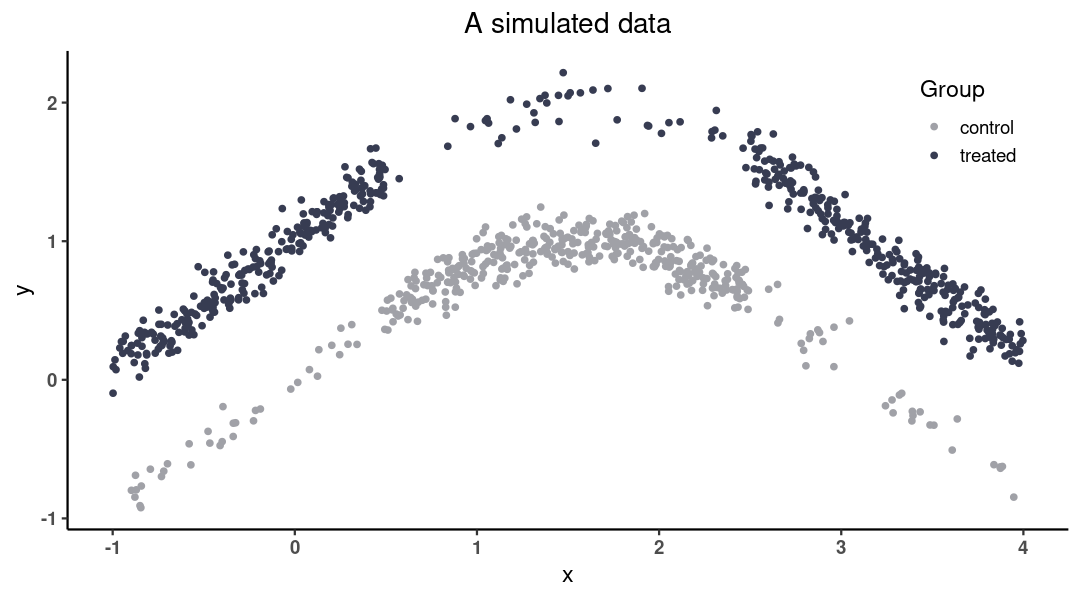

In [27]:
data %>%
    ggplot(aes(x, y, color=d_factor)) + geom_point() +
    labs(
        color='Group',
        title='A simulated data'
    ) +
    theme_classic(base_size=14) +
    scale_color_manual(values=c('#a0a1a7', '#373c52')) +
    theme(plot.title=element_text(hjust=0.5),
            axis.text.x=element_text(face='bold'),
            axis.text.y=element_text(face='bold'),
            legend.position=c(0.9, 0.85)
    )

In [28]:
linear_reg <- lm(y ~ d + x, data=data)  # conditional on x 
stargazer(linear_reg, type='text')


                        Dependent variable:    
                    ---------------------------
                                 y             
-----------------------------------------------
d                            0.242***          
                              (0.030)          
                                               
x                            0.031***          
                              (0.010)          
                                               
Constant                     0.640***          
                              (0.027)          
                                               
-----------------------------------------------
Observations                   1,000           
R2                             0.070           
Adjusted R2                    0.068           
Residual Std. Error      0.467 (df = 997)      
F Statistic           37.691*** (df = 2; 997)  
Note:               *p<0.1; **p<0.05; ***p<0.01


From the simulated data, we know __the treatment effect should be 1__. However,
the linear regression estimated the effect as _0.242_. 

In [29]:
data_match <- Match(
    data$y, data$d, data$x, 
    M=5, Weight=2, caliper=0.05
)
summary(data_match)


Estimate...  0.99881 
AI SE......  0.033839 
T-stat.....  29.517 
p.val......  < 2.22e-16 

Original number of observations..............  1000 
Original number of treated obs...............  558 
Matched number of observations...............  209 
Matched number of observations  (unweighted).  1063 

Caliper (SDs)........................................   0.05 
Number of obs dropped by 'exact' or 'caliper'  349 



The matching estimate is much closer to the true treatment effect (_0.998_)
because it is not relying on false linearity assumptions. 

In [31]:
# illustration 
knn_reg <- knn.reg(
    train=dplyr::select(data, x, d),
    y=data$y,
    test=dplyr::select(data, x, d),
    k=10,
    algorithm='brute'
)

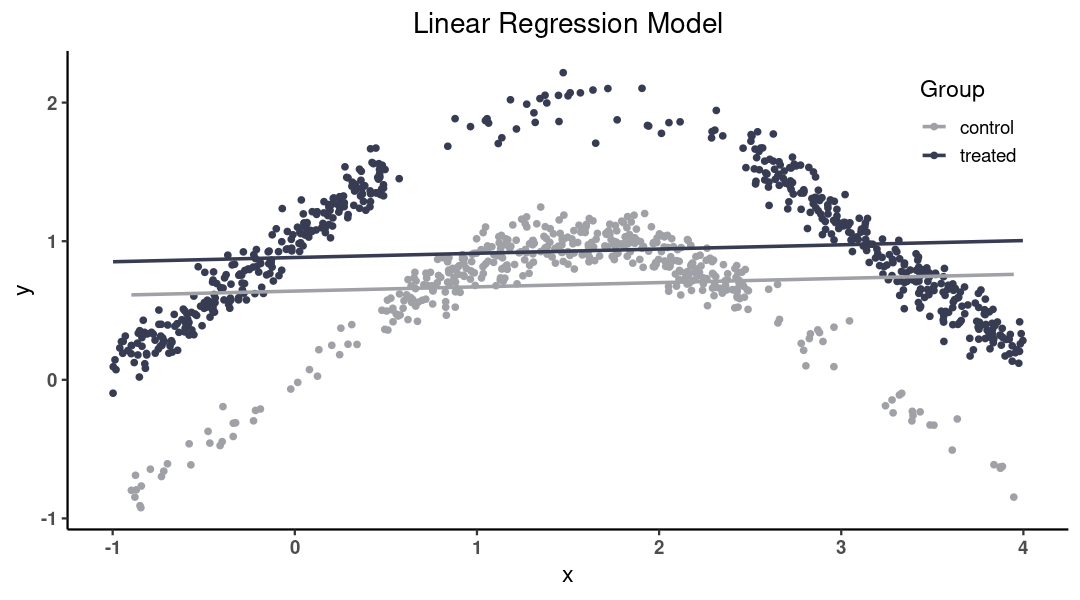

In [42]:
data %>%
    mutate(pred_knn=knn_reg$pred) %>%
    modelr::add_predictions(linear_reg, var='pred_linear') -> data_pred

p1 <- ggplot(data_pred) +
    aes(x=x, color=d_factor) + 
    geom_point(aes(y=y)) + 
    geom_line(aes(y=pred_linear), size=1) +
    theme_classic(base_size=14) +
    scale_color_manual(values=c('#a0a1a7', '#373c52')) +
    labs(title='Linear Regression Model', color='Group') + 
    theme(plot.title=element_text(hjust=0.5),
            axis.text.x=element_text(face='bold'),
            axis.text.y=element_text(face='bold'),
            legend.position=c(0.9, 0.85)
    )

p1

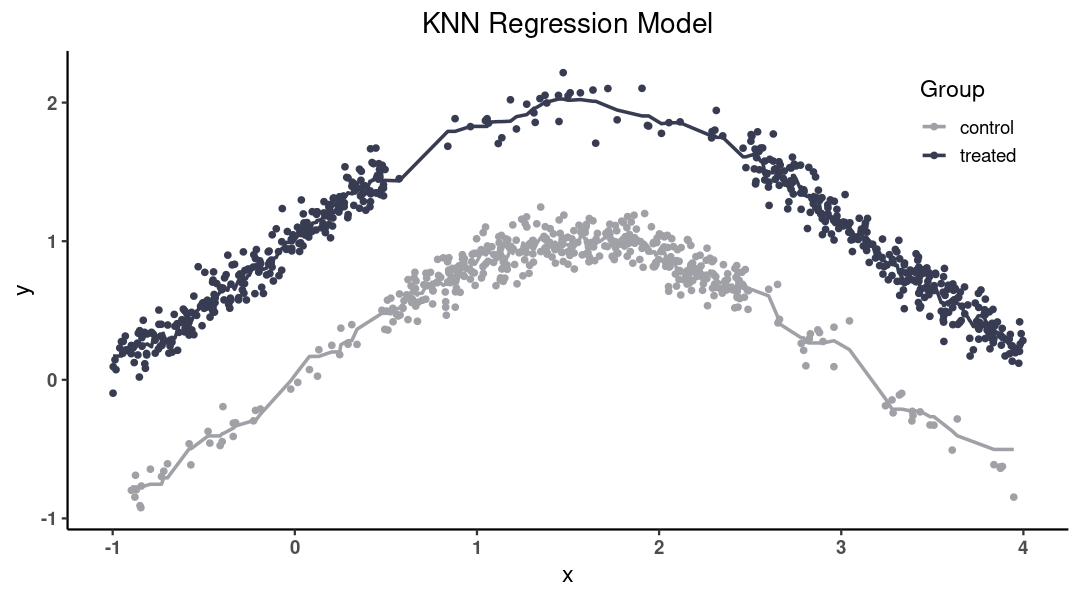

In [43]:
p2 <- ggplot(data_pred) +
    aes(x=x, color=d_factor) + 
    geom_point(aes(y=y)) + 
    geom_line(aes(y=pred_knn), size=1) +
    theme_classic(base_size=14) +
    scale_color_manual(values=c('#a0a1a7', '#373c52')) +
    labs(title='KNN Regression Model', color='Group') + 
    theme(plot.title=element_text(hjust=0.5),
            axis.text.x=element_text(face='bold'),
            axis.text.y=element_text(face='bold'),
            legend.position=c(0.9, 0.85)
    )

p2

Sadly, there is no free lunch, and the flexibility of Matching comes at a price: 
the __common support assumption__. In order to get a counterfactual estimate without a parametric model, we need to have observations with the same (or similar) covariate values and opposite treatment status for each of the original units. If we don’t, Matching will fail.

The common support assumption
$$
0<P(D=1 \mid X)<1
$$

implies that the probability of receiving treatment for each possible value of the vector $X$ is strictly within the unit interval: as is the probability of not receiving treatment. This assumption of common support ensures that there is sufficient overlap in the characteristics of treated and untreated units to find adequate matches.
When these assumptions are satisfied, the treatment assignment is said to be strongly ignorable in the terminology of Rosenbaum and Rubin (Biometrika, 1983).


However, Regression doesn’t have such a requisite. Instead, it leverages the parametric specification to get estimates by “extrapolation” in the areas without common support. And, if our parametric specification appropriately reflects the data generating process, such extrapolation is a reasonable way to handle these cases.

Let’s see an example with simulated data to understand better this idea. The code here will be very similar to the previous example, but with two key differences:

* Treatment assignment (`d`) is now a deterministic function of `x`: for some 
values of `x`, all the units get the treatment, and for others, nobody is treated. 
This kills the common support assumption and any hope of using Matching and getting a good estimate ☠️.

* However, now we assume that we know the non-linear function that links `x` 
with `y`. We put that knowledge in the regression specification 
(`y ~ d + sin(x)`) in order to get the extrapolation right.
Here is the simulated data:

In [77]:
data_no_common_support  <- tibble(
    x = runif(1000,-1, 4),
    # Note how `x` now affects `d` in a deterministic way
    # There is no `prob_d` and no `rbinom`
    d = ifelse(x > 0.5 & x < 2.5, 0, 1),
    noise = rnorm(1000, sd = 0.1),
    treat_effect = 1,
    # x->y and x->d, just like in the previous example
    y = sin(x) + d * treat_effect + noise
  ) %>%
  mutate(d_factor = factor(
    d,
    levels = c(0, 1),
    labels = c("Control", "Treated")
    )
)

head(data_no_common_support)

x,d,noise,treat_effect,y,d_factor
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.26610653,1,-0.05201009,1,1.2109669,Treated
1.57523262,0,0.02610776,1,1.0260979,Control
-0.05972431,1,0.06450790,1,1.0048191,Treated
3.27497052,1,-0.11863340,1,0.7483838,Treated
2.86387584,1,0.04583227,1,1.3199929,Treated
3.44062545,1,0.25284978,1,0.9582537,Treated


### What does the common support mean? 

Here we will use a graph to illustrate what the common support mean. 

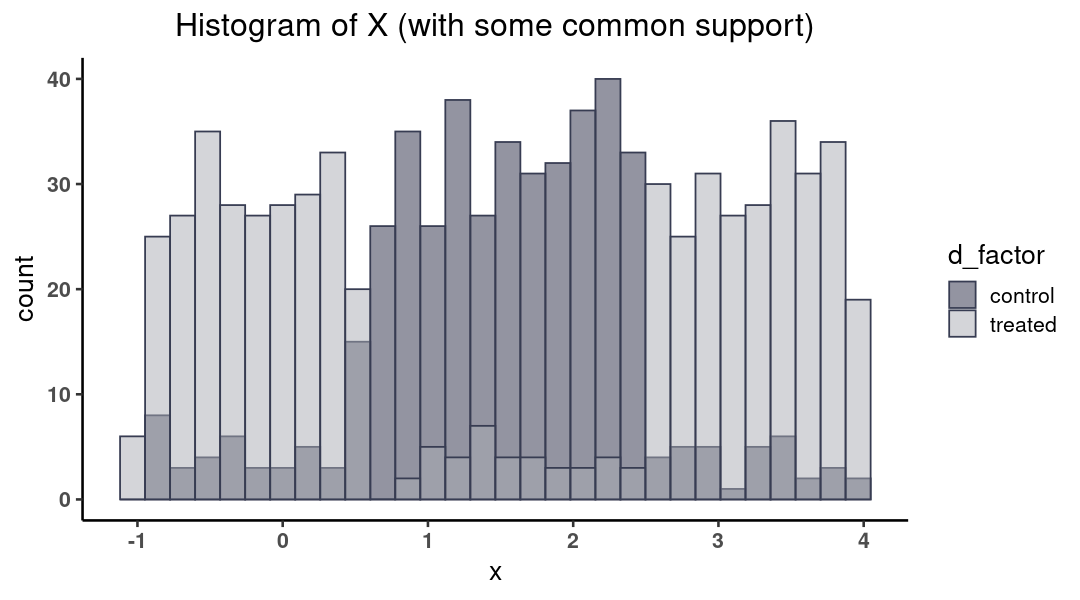

In [95]:
# denstity plot
data %>%
    ggplot(aes(x=x, fill=d_factor, color=d_factor)) +
    geom_histogram(
        position='identity', alpha=0.5,
        bins=30
    ) +
    labs(title='Histogram of X (with some common support)') +
    theme_classic(base_size=16) + 
    scale_color_manual(values=c('#373c52', '#373c52')) +
    scale_fill_manual(values=c('#282b44', '#aaabb3')) +
    theme(plot.title=element_text(hjust=0.5),
            axis.text.x=element_text(face='bold'),
            axis.text.y=element_text(face='bold')
    )

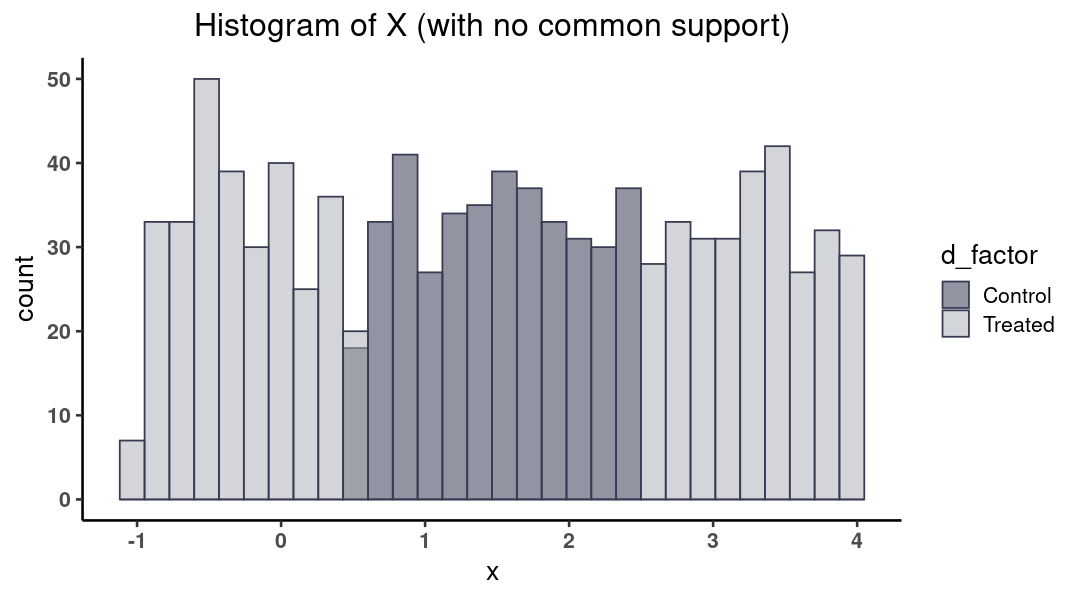

In [97]:
data_no_common_support %>%
    ggplot(aes(x=x, fill=d_factor, color=d_factor)) +
    geom_histogram(
        position='identity', alpha=0.5,
        bins=30
    ) +
    labs(title='Histogram of X (with no common support)') +
    theme_classic(base_size=16) + 
    scale_color_manual(values=c('#373c52', '#373c52')) +
    scale_fill_manual(values=c('#282b44', '#aaabb3')) +
    theme(plot.title=element_text(hjust=0.5),
            axis.text.x=element_text(face='bold'),
            axis.text.y=element_text(face='bold')
    )

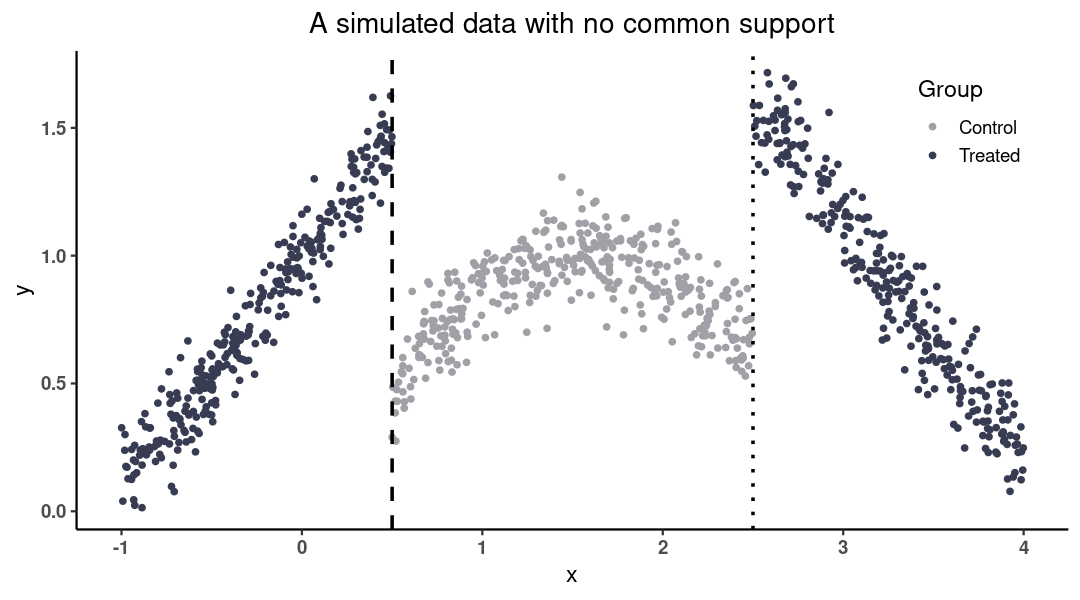

In [105]:
data_no_common_support %>%
    ggplot(aes(x, y, color=d_factor)) + geom_point() +
    labs(
        color='Group',
        title='A simulated data with no common support'
    ) +
    theme_classic(base_size=14) +
    scale_color_manual(values=c('#a0a1a7', '#373c52')) +
    theme(plot.title=element_text(hjust=0.5),
            axis.text.x=element_text(face='bold'),
            axis.text.y=element_text(face='bold'),
            legend.position=c(0.9, 0.85)
    ) +
    geom_vline(xintercept=0.5, size=1, linetype='dashed') + 
    geom_vline(xintercept=2.5, size=1, linetype='dotted')

In [106]:
# rit with regression
linear_reg_no_cs <- lm(
    y ~ d + sin(x), data=data_no_common_support
)
stargazer(linear_reg_no_cs, type='text')


                        Dependent variable:    
                    ---------------------------
                                 y             
-----------------------------------------------
d                            0.984***          
                              (0.012)          
                                               
sin(x)                       0.998***          
                              (0.010)          
                                               
Constant                       0.013           
                              (0.010)          
                                               
-----------------------------------------------
Observations                   1,000           
R2                             0.909           
Adjusted R2                    0.908           
Residual Std. Error      0.103 (df = 997)      
F Statistic         4,953.465*** (df = 2; 997) 
Note:               *p<0.1; **p<0.05; ***p<0.01


The coefficient for `d` is closed to 1, which is equal to the value
we set in the simulation. 

In [107]:
# check the matching method
match_no_cs <- Match(
    data_no_common_support$y,
    data_no_common_support$d,
    data_no_common_support$x,
    M=5,
    Weight=2,
    caliper=0.05
)
summary(match_no_cs)


Estimate...  0.96981 
AI SE......  0.038808 
T-stat.....  24.99 
p.val......  < 2.22e-16 

Original number of observations..............  1000 
Original number of treated obs...............  605 
Matched number of observations...............  20 
Matched number of observations  (unweighted).  100 

Caliper (SDs)........................................   0.05 
Number of obs dropped by 'exact' or 'caliper'  585 



Here matched number of observations is only __20__, which means that
there is no common support. However, in our first simulation, we have
__209__ observation matched at least. 

> Take away: regression has more bias, whereas matching has more variance.
It is important to check _the common support assumption_ when you want to use
matching method. 

## Propensity score methods

Before we explain what the propensity score method is, let's replicate a
classical paper bz Lalonde (1986). The idea is to evaluate
the econometric evaluations of traning programs with _experimental data_
and _observable data_. Lalonde(1986)'s paper shows that many of the econometric
procedures do not replicate the experimentally determined results, and it
suggests that researchers should be aware of the potential for specification
errors in other nonexperimental evaluations. 

### Regression on experimental dataset

In [2]:
nsw_lalonde_male <- read_dta('http://www.nber.org/~rdehejia/data/nsw.dta')
head(nsw_lalonde_male)  # dim = 722 x 10 

data_id,treat,age,education,black,hispanic,married,nodegree,re75,re78
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Lalonde Sample,1,37,11,1,0,1,1,0,9930.0459
Lalonde Sample,1,22,9,0,1,0,1,0,3595.8940
Lalonde Sample,1,30,12,1,0,0,0,0,24909.4492
Lalonde Sample,1,27,11,1,0,0,1,0,7506.1460
Lalonde Sample,1,33,8,1,0,0,1,0,289.7899
Lalonde Sample,1,22,9,1,0,0,1,0,4056.4939


* treatment 1 if in NSW Job Training Program; 0 otherwise
* age Age in years
* education Education (# years)
* black 1 if black; 0 otherwise
* hispanic 1 if hispanic; 0 otherwise
* married 1 if married; 0 otherwise
* nodegree 1 if no high school degree; 0 otherwise
* re75 Real earnings in 1975
* re78 Real earnings in 1978 (outcome variable)

In [4]:
# reproduce Lalonde 1986 table 3
nsw_lalonde_male %>%
    group_by(treat) %>%
    summarize(
        re75_mean=mean(re75), 
        re75_se=sd(re75)/sqrt(length(re75)),
        re78_mean=mean(re78),
        re78_se=sd(re78)/sqrt(length(re78)),
        count=n()
        ) %>%
        mutate(treat=factor(
            treat, 
            levels=c(0, 1),
            labels=c('Controls', 'Treatments'))) %>%
            t() %>% as.data.frame() %>%
            mutate(
                treatments=suppressWarnings(as.numeric(V2)),
                controls=suppressWarnings(as.numeric(V1)),
                ) %>%
            slice(-1)%>%
            mutate(diff=treatments-controls)

,V1,V2,treatments,controls,diff
,<chr>,<chr>,<dbl>,<dbl>,<dbl>
re75_mean,3026.683,3066.098,3066.0980,3026.6830,39.4150
re75_se,252.2977,282.8697,282.8697,252.2977,30.5720
re78_mean,5090.048,5976.352,5976.3520,5090.0480,886.3040
re78_se,277.3680,401.7594,401.7594,277.3680,124.3914
count,425,297,297.0000,425.0000,-128.0000


In [38]:
# let's run regression
nsw_exp_reg <- lm(re78 ~ treat + age + education
                            + black + hispanic + married + nodegree,
                            data=nsw_lalonde_male)
stargazer(nsw_exp_reg, type='text', omit.stat=c('ser', 'f'),
            no.space=TRUE)


                 Dependent variable:    
             ---------------------------
                        re78            
----------------------------------------
treat                 793.609*          
                      (471.895)         
age                    20.105           
                      (36.491)          
education              205.879          
                      (180.928)         
black               -1,765.638**        
                      (803.488)         
hispanic              -133.947          
                     (1,053.144)        
married                540.991          
                      (644.978)         
nodegree              -522.315          
                      (749.177)         
Constant              4,268.577         
                     (2,624.619)        
----------------------------------------
Observations             722            
R2                      0.025           
Adjusted R2             0.015           
Note:        *p

We can see that the simple regression estiates treatment effect is around
_793_, which is not very different from _886_. 

### Regression on observable dataset

In [5]:
psid <- read_dta('http://www.nber.org/~rdehejia/data/psid_controls.dta')
head(psid)

data_id,treat,age,education,black,hispanic,married,nodegree,re74,re75,re78
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
PSID,0,47,12,0,0,0,0,0,0,0
PSID,0,50,12,1,0,1,0,0,0,0
PSID,0,44,12,0,0,0,0,0,0,0
PSID,0,28,12,1,0,1,0,0,0,0
PSID,0,54,12,0,0,1,0,0,0,0
PSID,0,55,12,0,1,1,0,0,0,0


In [61]:
# trading out the experimental control group data
psid %>%
    filter(re78!=0) %>%
    dplyr::select(-re74) %>%
    bind_rows(nsw_lalonde_male) -> nsw_psid

table(nsw_psid$treat)



   0    1 
2629  297 

In [62]:
psid_reg <- lm(re78 ~ treat + age + education
                            + black + hispanic + married + nodegree,
                            data=nsw_psid)
stargazer(psid_reg, type='text', omit.stat=c('ser', 'f'),
            no.space=TRUE)


                 Dependent variable:    
             ---------------------------
                        re78            
----------------------------------------
treat               -3,544.348***       
                      (787.172)         
age                  315.456***         
                      (23.267)          
education           1,679.836***        
                      (115.056)         
black               -5,702.692***       
                      (535.828)         
hispanic             -1,820.355*        
                     (1,040.006)        
married             6,102.884***        
                      (569.200)         
nodegree             -1,098.400         
                      (686.582)         
Constant           -11,168.720***       
                     (1,883.482)        
----------------------------------------
Observations            2,926           
R2                      0.417           
Adjusted R2             0.416           
Note:        *p

The coefficent becomes negative. 

In [6]:
# cps dataset
cps <- read_dta('http://www.nber.org/~rdehejia/data/cps_controls.dta')
head(cps)

data_id,treat,age,education,black,hispanic,married,nodegree,re74,re75,re78
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CPS1,0,45,11,0,0,1,1,21516.670,25243.551,25564.670
CPS1,0,21,14,0,0,0,0,3175.971,5852.565,13496.080
CPS1,0,38,12,0,0,1,0,23039.020,25130.760,25564.670
CPS1,0,48,6,0,0,1,1,24994.369,25243.551,25564.670
CPS1,0,18,8,0,0,1,1,1669.295,10727.610,9860.869
CPS1,0,22,11,0,0,1,1,16365.760,18449.270,25564.670


In [7]:
nsw_lalonde_male %>%
    filter(treat==1) -> foo1

cps %>%
    dplyr::select(-re74) -> foo2

bind_rows(foo1, foo2) %>%
    group_by(data_id) %>%
    summarize(
        N=n(),
        across(where(is.numeric), mean)
    ) %>%
    mutate(across(where(is.numeric), round, 2)) %>%
    pivot_longer(cols=-data_id) %>%
    pivot_wider(names_from=data_id, values_from=value) %>%
    mutate(Diff=CPS1-`Lalonde Sample`)

name,CPS1,Lalonde Sample,Diff
<chr>,<dbl>,<dbl>,<dbl>
N,15992.00,297.00,15695.00
treat,0.00,1.00,-1.00
age,33.23,24.63,8.60
education,12.03,10.38,1.65
black,0.07,0.80,-0.73
hispanic,0.07,0.09,-0.02
married,0.71,0.17,0.54
nodegree,0.30,0.73,-0.43
re75,13650.80,3066.10,10584.70


 As you can see, the treatment group appears to be very different on average 
 from the control group CPS sample along nearly every covariate listed. 
 The NSW participants are more black, more Hispanic, younger, less likely 
 to be married, more likely to have no degree and less schooling, more likely 
 to be unemployed in 1975, and more likely to have considerably lower earnings 
 in 1975. In short, the two groups are not exchangeable on observables 
 (and likely not exchangeable on unobservables either).

### Estimating propensity score

In [8]:
nsw_dw <- read_dta('https://github.com/scunning1975/mixtape/raw/master/nsw_mixtape.dta')
head(nsw_dw)

data_id,treat,age,educ,black,hisp,marr,nodegree,re74,re75,re78
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Dehejia-Wahba Sample,1,37,11,1,0,1,1,0,0,9930.0459
Dehejia-Wahba Sample,1,22,9,0,1,0,1,0,0,3595.8940
Dehejia-Wahba Sample,1,30,12,1,0,0,0,0,0,24909.4492
Dehejia-Wahba Sample,1,27,11,1,0,0,1,0,0,7506.1460
Dehejia-Wahba Sample,1,33,8,1,0,0,1,0,0,289.7899
Dehejia-Wahba Sample,1,22,9,1,0,0,1,0,0,4056.4939


In [28]:
cps_dw <- read_dta('https://github.com/scunning1975/mixtape/raw/master/cps_mixtape.dta')
head(cps_dw)

data_id,treat,age,educ,black,hisp,marr,nodegree,re74,re75,re78
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CPS1,0,45,11,0,0,1,1,21516.670,25243.551,25564.670
CPS1,0,21,14,0,0,0,0,3175.971,5852.565,13496.080
CPS1,0,38,12,0,0,1,0,23039.020,25130.760,25564.670
CPS1,0,48,6,0,0,1,1,24994.369,25243.551,25564.670
CPS1,0,18,8,0,0,1,1,1669.295,10727.610,9860.869
CPS1,0,22,11,0,0,1,1,16365.760,18449.270,25564.670


[1] 15992    11

In [31]:
bind_rows(cps_dw, nsw_dw) %>%
    mutate(
        agesq = age^2,
        agecube = age^3,
        educsq = educ*educ,
        u74 = case_when(re74 == 0 ~ 1, TRUE ~ 0),
        u75 = case_when(re75 == 0 ~ 1, TRUE ~ 0),
        interaction1 = educ*re74,
        re74sq = re74^2,
        re75sq = re75^2,
        interaction2 = u74*hisp
    ) -> nsw_dw_cps

This last point also implies that we shouldn’t include in the propensity 
score model any variables that are not confounders 
(i.e. that don’t affect both the treatment status and the outcome) even if 
they improve the precision of the treatment status prediction.

> __We shouldn’t include in the propensity score model any variables that are not confounders__

In [32]:
# estimate the probability
logit_nsw <- glm(treat ~ age + agesq + agecube + educ + educsq + 
                   marr + nodegree + black + hisp + re74 + re75 + u74 +
                   u75 + interaction1, family = binomial(link = "logit"),
                   data = nsw_dw_cps)

In [33]:
stargazer(
    logit_nsw, type='text',
    omit.stat=c('ser', 'f'),
    no.space=T)


                      Dependent variable:    
                  ---------------------------
                             treat           
---------------------------------------------
age                        1.237***          
                            (0.307)          
agesq                      -0.034***         
                            (0.010)          
agecube                    0.0003***         
                           (0.0001)          
educ                        0.507**          
                            (0.217)          
educsq                     -0.033***         
                            (0.012)          
marr                       -0.917***         
                            (0.226)          
nodegree                     0.149           
                            (0.284)          
black                      3.281***          
                            (0.266)          
hisp                       1.608***          
                            (0.39

In [34]:
nsw_dw_cps %>%
    mutate(pscore=logit_nsw$fitted.values) %>%
    group_by(treat) %>%
    summarize(pscore_mean=mean(pscore))

treat,pscore_mean
<dbl>,<dbl>
0,0.008857852
1,0.221849674


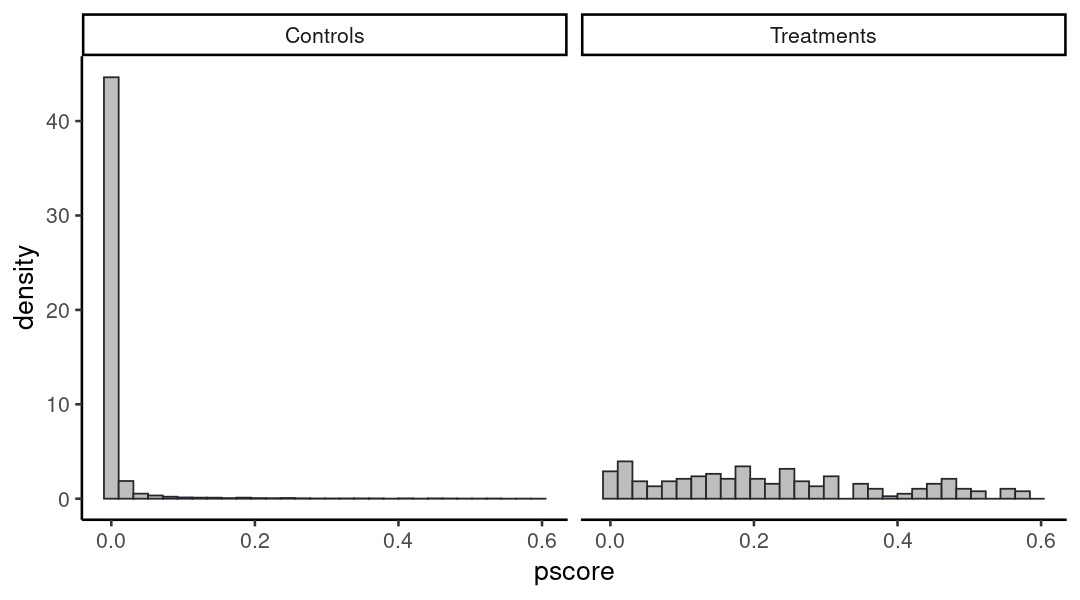

In [36]:
nsw_dw_cps %>%
    mutate(
        treat=factor(
            treat, levels=c(0, 1),labels=c('Controls', 'Treatments')
            ),
        pscore=logit_nsw$fitted.values
        ) %>%
    ggplot(aes(x=pscore)) +
    facet_wrap(vars(treat)) +
    geom_histogram(aes(y=..density..),
                        bins=30, color='#27262c',
                        fill='gray') +
    theme_classic(base_size=16)

The definition of the propensity score is the selection probability conditional on the confounding variables:

$$p(X)=Pr(D=1 | X)$$

We have already discussed the meaning of common support. This simply means that 
for any probability, there must be units in both the treatment group 
and the control group. The conditional independence assumption 
simply means that the backdoor criterion is met in the data by conditioning on
a vector $X$. Or, put another way, conditional on $X$, 
the assignment of units to the treatment is as good as random.

In our _logit_ model, we estimated the following model

$$Pr(D=1 | X) = F(\beta_0 + \beta X)$$

The probability of treatment is spread out across the units in the treatment group, but there is a very large mass of nearly zero propensity scores in the CPS. How do we interpret this? What this means is that the characteristics of individuals in the treatment group are rare in the CPS sample. This is not surprising given the strong negative selection into treatment. These individuals are younger, less likely to be married, and more likely to be uneducated and a minority. The lesson is, if the two groups are significantly different on background characteristics, then the propensity scores will have grossly different distributions by treatment status.




### Estimating ATE with propensity score

In [37]:
# add one column for pscore
nsw_dw_cps %>%
    mutate(pscore = logit_nsw$fitted.values) %>%
    # add inverse probability weight
    mutate(
        d1 = treat/pscore,  # weight for treatment group
        d0 = (1-treat)/(1-pscore)  # weight for control group
    ) %>%
    mutate (
        y1 = treat*re78/pscore,
        y0 = (1-treat)*re78/(1-pscore),
        diff = y1 -y0, 
        norm_diff = y1/(sum(d1)/n()) - y0/(sum(d0)/n())
    ) %>%
    summarize(att=mean(diff), normlized_att=mean(norm_diff))

att,normlized_att
<dbl>,<dbl>
-12504.9,-7278.858


When we estimate the treatment effect using inverse probability weighting using the non-normalized weighting procedure described earlier, we find an estimated ATT of
$-12505$ Using the normalization of the weights, we get $-7279$. Why is this so much different than what we get using the experimental data?

This is due to the extreme values of propensity scores we estimated. We will
estimate the ATT again with trimmed dataset. 
 

In [40]:
# trimming propensity score
nsw_dw_cps %>%
    mutate(pscore = logit_nsw$fitted.values) %>%
    filter(pscore > 0.1 & pscore < 0.9) %>%
    # add inverse probability weight
    mutate(
        d1 = treat/pscore,  # weight for treatment group
        d0 = (1-treat)/(1-pscore)  # weight for control group
    ) %>%
    mutate (
        y1 = treat*re78/pscore,
        y0 = (1-treat)*re78/(1-pscore),
        diff = y1 -y0, 
        norm_diff = y1/(sum(d1)/n()) - y0/(sum(d0)/n())
    ) %>%
    summarize(att=mean(diff), normlized_att=mean(norm_diff))

att,normlized_att
<dbl>,<dbl>
2294.72,1357.211


 Now we find $2,294 using the non-normalized weights and $1,357 using the normalized weights. This is very similar to what we know is the true causal effect using the experimental data, $1794. 

In [50]:
# difference from experimental data
nsw_dw %>%
    group_by(treat) %>%
    summarize(
        re78_mean=mean(re78)
    ) %>% t() %>% as.data.frame() %>%
    mutate(ate=V2-V1)

,V1,V2,ate
,<dbl>,<dbl>,<dbl>
treat,0.000,1.000,1.000
re78_mean,4554.801,6349.144,1794.342


We still need to calculate standard errors, such as based on a bootstrapping method. 